 # A simple test of using `optuna` for hyperparameter optimization

In [1]:
import time
from types import SimpleNamespace

import pydove as dv
from tqdm.notebook import tqdm

import torch
from cpcn import PCNetwork, load_mnist, Trainer

import optuna
from optuna.trial import TrialState

 ## Defining the optimization

In [2]:
def optuna_reporter(trial: optuna.trial.Trial, ns: SimpleNamespace):
    trial.report(ns.val_loss, ns.epoch)

    # early pruning
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()


def create_pcn(trial):
    # n_hidden = trial.suggest_int("n_hidden", 1, 3)
    n_hidden = 1
    # dims = [28 * 28]
    # for i in range(n_hidden):
    #     n_units = trial.suggest_int(f"n_units_l{i}", 3, 64)
    #     dims.append(n_units)
    # dims.append(10)
    dims = [28 * 28, 5, 10]

    z_lr = trial.suggest_float("z_lr", 1e-5, 0.2, log=True)
    net = PCNetwork(dims, lr_inference=z_lr, it_inference=50, variances=1, bias=False)

    return net


def objective(
    trial: optuna.trial.Trial, n_epochs: int, dataset: dict, device: torch.device
) -> float:
    net = create_pcn(trial).to(device)

    optimizer_type = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    optimizer_class = getattr(torch.optim, optimizer_type)
    # optimizer_class = torch.optim.Adam
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)

    rep_gamma = trial.suggest_float("rep_gamma", 1e-7, 0.2, log=True)

    trainer = Trainer(net, dataset["train"], dataset["validation"])
    trainer.set_optimizer(optimizer_class, lr=lr)
    trainer.add_scheduler(
        lambda optim: torch.optim.lr_scheduler.ExponentialLR(optim, gamma=1 - rep_gamma)
    )

    trainer.add_epoch_observer(lambda ns: optuna_reporter(trial, ns))
    results = trainer.run(n_epochs)

    return results.validation.pc_loss[-1]

In [3]:
# minimizing PC loss
t0 = time.time()

device = torch.device("cpu")

n_epochs = 50
dataset = load_mnist(n_train=2000, n_validation=1000, batch_size=100)

study = optuna.create_study(direction="minimize")
study.optimize(
    lambda trial: objective(trial, n_epochs, dataset, device),
    n_trials=200,
    timeout=1800,
    show_progress_bar=True,
)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

t1 = time.time()

[I 2022-04-22 15:46:51,170] A new study created in memory with name: no-name-77a68a70-4ab4-4e9a-a295-446827340ee7
/mnt/home/ttesileanu/miniconda3/envs/cpcn/lib/python3.9/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2022-04-22 15:47:36,612] Trial 0 finished with value: 0.4091533780097961 and parameters: {'z_lr': 1.55313346369138e-05, 'optimizer': 'RMSprop', 'lr': 7.009228163037984e-05, 'rep_gamma': 1.0994543507895935e-06}. Best is trial 0 with value: 0.4091533780097961.
[I 2022-04-22 15:48:21,270] Trial 1 finished with value: 0.3196363776922226 and parameters: {'z_lr': 0.030982911050303995, 'optimizer': 'SGD', 'lr': 0.007883917380251172, 'rep_gamma': 0.0003888369712551073}. Best is trial 1 with value: 0.3196363776922226.
[I 2022-04-22 15:49:09,402] Trial 2 finished with value: 0.3384138703346252 and parameters: {'z_lr': 0.0006558296928443135, 'optimizer': 'Adam', 'lr': 0.001360766562640757, 'rep_gamma': 0.11962902010790549}. Best is trial 1 with value: 0.3196363776922226.
[I 2022-04-22 15:49:55,838] Trial 3 finished with value: 0.3058592826128006 and parameters: {'z_lr': 0.00925915714785049, 'optimizer': 'SGD', 'lr': 0.020872283638775045, 'rep_gamma': 9.975457889325983e-05}. Best is trial 3 wit

In [4]:
print(
    f"{len(study.trials)} trials in {t1 - t0:.1f} seconds: "
    f"{len(complete_trials)} complete, {len(pruned_trials)} pruned."
)

trial = study.best_trial
print(f"best pc_loss: {trial.value}, for params:")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

112 trials in 1819.8 seconds: 33 complete, 79 pruned.
best pc_loss: 0.26764023303985596, for params:
    z_lr: 0.010105783788220024
    optimizer: Adam
    lr: 0.004157609360972105
    rep_gamma: 0.011343868716670088


<ipython-input-5-83c13c1a414d>:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

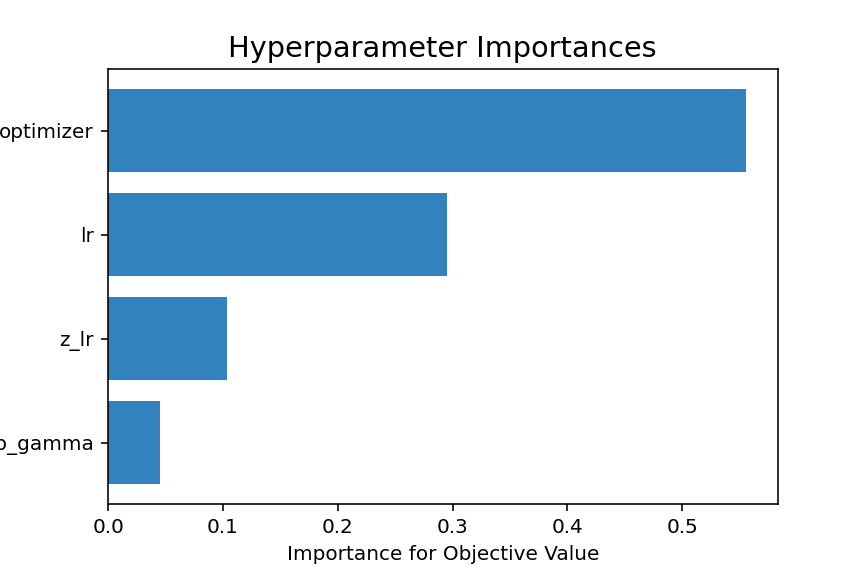

In [5]:
optuna.visualization.matplotlib.plot_param_importances(study)